# `logfs` Complexity Analysis

## Benchmarks

In [1]:
from logfs import LogFs, LogFsRamDisk
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class BenchmarkDisk(LogFsRamDisk):
    def __init__(self, block_size, block_count):
        super().__init__(block_size=block_size, block_count=block_count)
        self.block_size = block_size
        self.block_count = block_count

    def benchmark(self, data_size_bytes):
        data_size_blocks = data_size_bytes // self.block_size

        print(f"Data size: {data_size_bytes} bytes ({data_size_blocks} blocks)")
        print(f"Reads: {self.reads} (factor = {self.reads / data_size_blocks})")
        print(f"Writes: {self.writes} (factor = {self.writes / data_size_blocks})")

    def benchmark_reset(self):
        self.writes = 0
        self.reads = 0


BLOCK_SIZE = 512
BLOCK_COUNT = 300_000
GROOTINGS = b"grootings!"
KB = 1024
MB = KB * KB

In [3]:
def bench_groot(size_bytes, log=False, incremental=False, prefill=False):
    disk = BenchmarkDisk(block_size=BLOCK_SIZE, block_count=BLOCK_COUNT)
    fs = LogFs(
        disk=disk,
        block_size=BLOCK_SIZE,
        block_count=BLOCK_COUNT,
        format=True,
        rd_only=False
    )

    grootings_count = size_bytes // len(GROOTINGS)
    data = GROOTINGS * grootings_count

    file = fs.open("/test1.txt", "rwx")
    if prefill:
        fs.write(file, data)
        disk.benchmark_reset()
        fs.mount()
        fs.write(file, GROOTINGS * (MB // len(GROOTINGS)))
    else:
        if not incremental:
            fs.write(file, data)
        else:
            for _ in range(grootings_count):
                fs.write(file, GROOTINGS)

    if log:
        disk.benchmark(data_size_bytes=len(data))

    return (disk.reads + disk.writes) * BLOCK_SIZE, disk.writes * BLOCK_SIZE

In [4]:
FILE_SIZES = [
    100 * KB,
    500 * KB,
    1 * MB,
    5 * MB,
    10 * MB,
    20 * MB,
    50 * MB,
]

### Non-Incremental Complexity

Test writing an entire large file all at once.

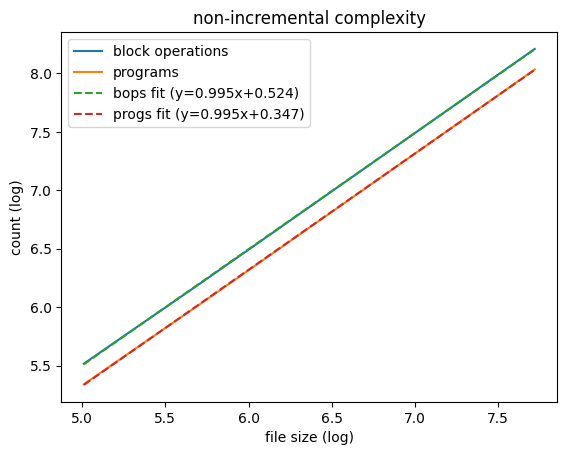

In [5]:
bops = []
progs = []
for size in FILE_SIZES:
    file_bops, file_progs = bench_groot(size, incremental=False)
    bops.append(file_bops)
    progs.append(file_progs)

log_sizes = np.log10(FILE_SIZES)
log_bops = np.log10(bops)
log_progs = np.log10(progs)
m_bops, b_bops = np.polyfit(log_sizes, log_bops, 1)
m_progs, b_progs = np.polyfit(log_sizes, log_progs, 1)

plt.figure()
plt.title("non-incremental complexity")

plt.plot(log_sizes, log_bops, label="block operations")
plt.plot(log_sizes, log_progs, label="programs")

plt.plot(
    log_sizes,
    m_bops * log_sizes + b_bops,
    "--",
    label=f"bops fit (y={m_bops:.3}x+{b_bops:.3})",
)
plt.plot(
    log_sizes,
    m_progs * log_sizes + b_progs,
    "--",
    label=f"progs fit (y={m_progs:.3}x+{b_progs:.3})",
)

plt.xlabel("file size (log)")
plt.ylabel("count (log)")
plt.legend()
plt.show()

### Incremental Complexity

Test writing a large file bit-by-bit.

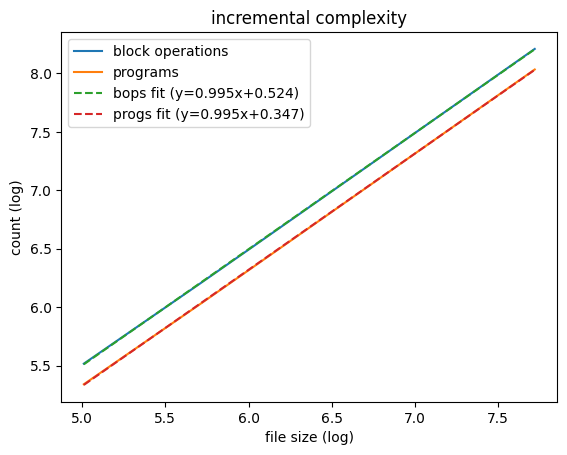

In [6]:
bops = []
progs = []
for size in FILE_SIZES:
    file_bops, file_progs = bench_groot(size, incremental=True)
    bops.append(file_bops)
    progs.append(file_progs)

log_sizes = np.log10(FILE_SIZES)
log_bops = np.log10(bops)
log_progs = np.log10(progs)
m_bops, b_bops = np.polyfit(log_sizes, log_bops, 1)
m_progs, b_progs = np.polyfit(log_sizes, log_progs, 1)

plt.figure()
plt.title("incremental complexity")

plt.plot(log_sizes, log_bops, label="block operations")
plt.plot(log_sizes, log_progs, label="programs")

plt.plot(
    log_sizes,
    m_bops * log_sizes + b_bops,
    "--",
    label=f"bops fit (y={m_bops:.3}x+{b_bops:.3})",
)
plt.plot(
    log_sizes,
    m_progs * log_sizes + b_progs,
    "--",
    label=f"progs fit (y={m_progs:.3}x+{b_progs:.3})",
)

plt.xlabel("file size (log)")
plt.ylabel("count (log)")
plt.legend()
plt.show()

### Prefill Complexity

Fill the filesystem with data of varying sizes, and then calculate the time to write a new, constant-sized large file.

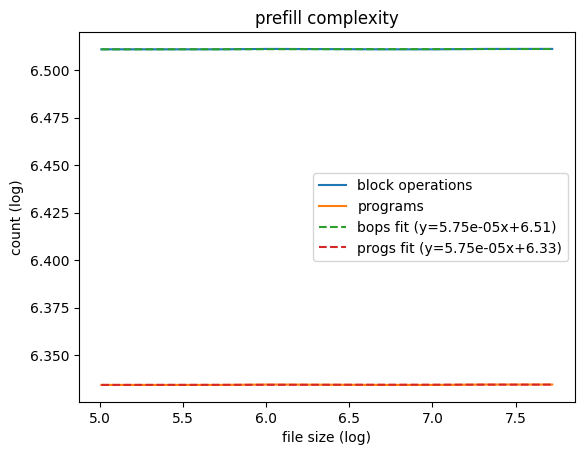

In [7]:
bops = []
progs = []
for size in FILE_SIZES:
    file_bops, file_progs = bench_groot(size, prefill=True)
    bops.append(file_bops)
    progs.append(file_progs)

log_sizes = np.log10(FILE_SIZES)
log_bops = np.log10(bops)
log_progs = np.log10(progs)
m_bops, b_bops = np.polyfit(log_sizes, log_bops, 1)
m_progs, b_progs = np.polyfit(log_sizes, log_progs, 1)

plt.figure()
plt.title("prefill complexity")

plt.plot(log_sizes, log_bops, label="block operations")
plt.plot(log_sizes, log_progs, label="programs")

plt.plot(
    log_sizes,
    m_bops * log_sizes + b_bops,
    "--",
    label=f"bops fit (y={m_bops:.3}x+{b_bops:.3})",
)
plt.plot(
    log_sizes,
    m_progs * log_sizes + b_progs,
    "--",
    label=f"progs fit (y={m_progs:.3}x+{b_progs:.3})",
)

plt.xlabel("file size (log)")
plt.ylabel("count (log)")
plt.legend()
plt.show()

## Conclusion

### Results

Looking at the graphs, we can pull some conclusions about `littlefs` performance:

1. Writing large files (>10MB) approaches $O(n^{2})$ runtime complexity. It could even be worse, since the graph is clearly trending upwards, but larger files take too long to run. This is true both if we call `write` bit-by-bit ("incremental complexity"), or write the whole file all at once ("non-incremental complexity"). 
2. The time to write a single write may be approaching $O(n)$ (this is expected from the previous result). See "prefill complexity" graph, where we write a file of varying size, and then benchmark writing a new, 1MB size file. This increases linearly.
3. Program operations scale linearly with the size of the data on the filesystem (this is good, and the theoretically best value we could hope to achieve).

This is very bad! We want to have high-bandwidth data logging, which makes these results unacceptable. Assuming we want to write $20kB/s$ (a reasonable value given a 500kbps bus), we will reach $50Mb$ in about 40 minutes of time with the car being on. With test days being hours in length, we will certaintly observe these time complexities in practice.

### Why?

`littlefs` is designed for resource-constrained microcontrollers, where power resilience is essential. It was also designed to be a general-purpose filesystem, with all the capabilities of a traditional filesystem. Neither of these requirements go hand-in-hand with high-bandwidth data logging - so this was probably not a priority in `littlefs`'s design. Fair enough, but this means we may need to select a different filesystem.

### Next Steps

Find/write a filesystem that has:

1. Wear-levelling
2. Power-loss resilience
3. **$O(n)$ time complexity to write data to a file, always! (where n is the size of the file).**